# PyPick: seismic event picking using Matplotlib and machine learning
*by [Alan Richardson](mailto:alan@ausargeo.com) ([Ausar Geophysical](http://www.ausargeo.com))*

Picking, either arrivals in data or horizons in migrated images, is a common task in seismic processing. I wanted to try doing it using Matplotlib so that I could pick data on remote servers using a Jupyter notebook and also easily have access to the picks in Python for further processing. It additionally seemed like a task that might be a fun potential application of machine learning.

The result is rather slow and a bit fragile, but it seems to work moderately well. It is just a toy project at the moment, so I don't know whether it would work on realistically-sized datasets.

## Method

### Picking with Matplotlib
One really nice feature of Matplotlib is that it can use several different backends. These allow it to run in different situations, such as on different operating systems, and, notably, in web browsers using Jupyter notebooks. Writing a picking utility using Matplotlib thus means that it can run locally on a computer, and also on a remote server accessed via a web browser.

A second feature of Matplotlib that is critical for this application is that it supports event triggers. Clicking on the plot can trigger an event that passes the location of the click to a function I have written. This is understandably difficult for Matplotlib to do across multiple backends, but it worked for me both locally (using the Qt4 backend) and in a Jupyter notebook, although it is much slower than I would like and is sometimes a bit temperamental. I initially considered using [`pyplot.ginput`](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.ginput.html), but this wasn't supported by the Jupyter notebook backend. The [`mpl_connect`](https://matplotlib.org/users/event_handling.html) function did work, though, and supports both mouse clicks and button presses. To enable interactive plots in Jupyter notebooks, you need to use the `%matplotlib notebook` magic function, rather than the more common `%matplotlib inline` (which renders the plots as static PNG images).

### Predicting picks using machine learning
We don't want to have to pick the event in every frame of data. In the case of seismic data, we would like to be able to pick the event on a few gathers spread over the volume, and then have the computer predict the picks for the rest of the data. This is often accomplished with a combination of interpolation and peak/trough detection, but I decided to try applying machine learning tools to it.

I split the task into two parts. The first consists of predicting the approximate location of a trace's pick. For this I use regression methods from [Scikit-learn](http://scikit-learn.org/), such as [linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) or [support vector machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). I allow the user to specify which method to use, so the parameters can be chosen, or the regression method could even be wrapped in a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). This approximate pick is used to isolate a window of data that hopefully contains the true pick location, which is then passed to the second prediction step.

The second part of the prediction uses a single layer convolutional neural network to identify the pick location within the window provided by the first part. It can also use a user supplied function instead. Using a neural network rather than peak/trough detection means that, if desired, you do not need to pick along a peak or trough. It also creates the possibility that the network could detect more complicated waveforms than simple peak or tough detection, potentially improving its ability to identify the correct event. For this neural network part, I use [TensorFlow](https://www.tensorflow.org/).

## Example
To test the code, I will try to pick the first break in the [2D Alaska 31-81 dataset](http://wiki.seg.org/wiki/Alaska_2D_land_line_31-81). I used [Karl Schleicher's processing flow](http://s3.amazonaws.com/open.source.geoscience/open_data/alaska/alaska31-81.tar.gz) to remove auxiliary traces and add geometry to the dataset. I then used my [netcdf_segy](https://github.com/ar4/netcdf_segy) tool to convert the data to NetCDF format, which I load below.

Note that I use the `%matplotlib notebook` magic function to specify that I want to use the interactive backend.

In [1]:
import pypick.pypick
import pypick.predict_picks
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
data = xr.open_dataset('allshots.nc')

The pypick tool requires that you pass arrays containing the frame parameters (such as shot number for shot gathers), and trace parameters (such as receiver coordinates for shot gathers), so I form those in the following cell. I use signed offset, absolute offset, receiver X position, and receiver elevation for the trace parameters.

The frame parameters array must contain at least two columns. The first two columns will be used as coordinates for making a scatter plot that allows the user to choose which frames to pick. Since this is a 2D dataset (a single line of sources), I just want the frames to be arranged in a line, so I set the second column of the frame parameters array to be all zeros.

In [3]:
num_frames, frame_len, trace_len = data.Samples.shape
frame_params = np.zeros([num_frames, 2], dtype=np.float32)
frame_params[:, 0] = data.FieldRecord
trace_params = np.concatenate([data.offset.values[:,:,np.newaxis],
                               np.abs(data.offset.values[:,:,np.newaxis]),
                               data.GroupX.values[:,:,np.newaxis],
                               data.ReceiverGroupElevation.values[:,:,np.newaxis]],
                              axis=2)

In [4]:
print(frame_params.shape, trace_params.shape)

(55, 2) (55, 96, 4)


In [5]:
data.Samples.shape

(55, 96, 3000)

To make the data easier to pick, I crudely balance the trace amplitude by dividing each trace by its maximum amplitude. Applying AGC would also have been a good choice. 

In [4]:
data['normalised_Samples'] = data.Samples/np.max(np.abs(data.Samples), axis=2)

To get started, we need to create a `Pypicks` object. We pass the data, frame and trace parameters, the methods for doing the approximate (step 1) and fine (step 2) pick prediction, and the length of the window that we extract around the approximate picks. If you have already done some picking on this dataset, you can also pass your existing picks.

Because pick prediction takes time, you may want to turn it off while you are doing picking by passing  `perform_prediction=False`. You can turn it on again later by setting the `perform_prediction` attribute of your `Pypicks` object to `True`, or you could recreate a new `Pypicks` object with `perform_prediction=True` (the default) and `picks` equal to the `picks` attribute from the previous object (so your existing picks get copied to the new one).

In [9]:
picks = pypick.pypick.Pypicks(data.normalised_Samples.values, frame_params, trace_params,
                              perform_prediction=False)

/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Next, we do some picking by calling `pypick`. This launches a PyPlot figure that initially shows a scatter plot with each point representing a frame of the data. Clicking on one of the points will open that frame so that you can pick it. The image below shows this screen after picking several frames (they change to yellow when you have picked them).

In the picking screen, clicking on a point while pressing the 'a' key will update the pick at that location. Pressing the 'q' key saves the picks and exits the picking screen (returning to the screen that allows you to choose a frame). Pressing the 'x' key exits the picking screen without saving the picks from the current frame.

Once you have picked at least one frame, the tool will try to predict the picks on subsequent frames that are opened (unless you have turned this off, as I mentioned above). For the first few of these, the predictions will probably not be good, and so you may wish to delete many or all of them so that you can more easily make large adjustments. You can do this by holding down the 'd' key. Clicking and dragging while 'd' is pressed will create a rectangular selector that will delete all points within in. I have found that when doing this, I have to ensure that I am not in zoom or pan mode for it to work.

<IPython.core.display.Javascript object>


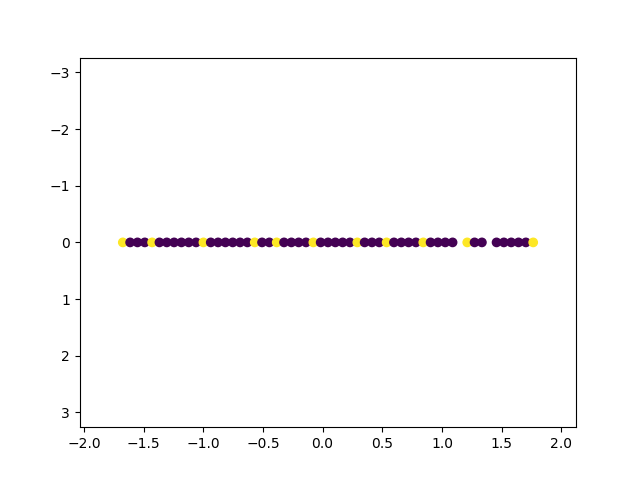

In [14]:
picks.pypick()

In the following cell I run `pypick` again and this time turn off interactive mode (converting the current view into a static PNG) in the picking screen to show you what that (the picking screen) looks like. I have zoomed in (another nice feature of interactive mode) to make accurate picking easier.

<IPython.core.display.Javascript object>


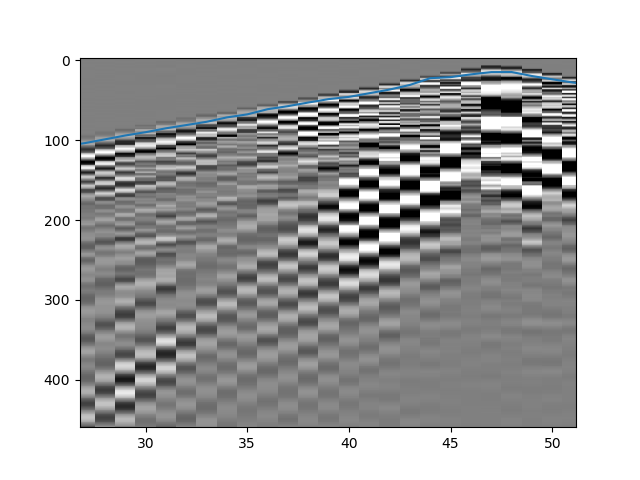

In [15]:
picks.pypick()

All of the saved picks are stored in the `picks` array of the `Pypicks` object.

In [24]:
picks.picks[0] # picks for the first frame

array([ 226.41675023,  220.44899611,  214.48124199,  208.51348787,
        202.54573375,  196.57797963,  194.68345452,  192.7889294 ,
        190.89440428,  186.27649931,  181.65859434,  177.04068936,
        172.42278439,  167.80487942,  163.18697445,  158.56906947,
        153.9511645 ,  149.33325953,  144.71535455,  140.09744958,
        135.47954461,  130.86163964,  126.24373466,  121.62582969,
        117.00792472,  112.32733325,  107.64674179,  102.96615032,
         98.28555886,   93.60496739,   88.92437593,   84.24378446,
         79.56319299,   74.88260153,   70.20201006,   65.5214186 ,
         60.84082713,   56.16023567,   51.4796442 ,   46.79905274,
         42.11846127,   37.4378698 ,   32.60683076,   27.77579171,
         22.94475266,   18.11371361,   13.28267456,   10.44088689,
         10.44088689,   14.85313617,   19.26538546,   23.67763474,
         28.08988403,   32.50213332,   36.9143826 ,   41.32663189,
         45.73888117,   50.15113046,   54.56337974,   58.97562

Let's save our picks to make sure that we don't lose them.

In [ ]:
ppicks = picks.picks
import pickle
pickle.dump(ppicks, open('picks.pickle', 'wb'))

In [20]:
 # I am finished with interactive plotting now
%matplotlib inline

To predict the picks for a frame, use the `predict` method of the `Pypicks` object, specifying the frame index.

In the cells below I compare the true picks for the first frame with the predicted picks for the same frame. These will not necessarily be the same, although we would like them to be as similar as possible. The accuracy is affected by the estimators that are used and their parameters. One interesting way to choose estimator parameters would be using [ipywidgets](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html) to create sliders to adjust the estimator parameters until you like the results. Another would be to use GridSearchCV, as I mentioned previously. I have decided to use the latter on both steps of the prediction.

In [57]:
picks = pypick.pypick.Pypicks(data.normalised_Samples.values, frame_params, trace_params,
                              approx_reg=GridSearchCV(SVR(), {'C': 10**np.arange(0, 4)}),
                              fine_reg=GridSearchCV(pypick.predict_picks.Fine_reg_tensorflow(batch_size=25,
                                                                                             num_steps=5000),
                                                    [{'box_size': [10], 'layer_len': [3, 5]},
                                                     {'box_size': [15], 'layer_len': [3, 5, 10]},
                                                     {'box_size': [20], 'layer_len': [3, 5, 10, 15]}]),
                              picks=ppicks)

/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:177: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/quake/home/alan_r/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


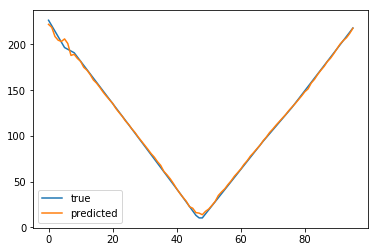

In [58]:
plt.figure()
plt.plot(ppicks[0], label='true')
plt.plot(picks.predict(0), label='predicted')
plt.legend();

We can check which parameters gave the best results in the grid search.

In [60]:
print(picks.approx_reg.best_params_, picks.fine_reg.best_params_)

{'C': 100} {'box_size': 10, 'layer_len': 5}


To predict picks for all of the frames, we call predict without an argument.

In [7]:
all_predict = picks.predict()

## Application: Tomo2D
Now that we have the first break picks for every shot, we can use a tool such as [Tomo2D](http://people.earth.yale.edu/software/jun-korenaga) to invert for the velocity model. The maximum offset in this dataset is only about 1.6 km, so first break tomography will only allow us to update the very near surface.

In [30]:
np.max(np.abs(data.offset.values)) * 0.305e-3 # maximum offset converted from ft to km

1.5936249999999998

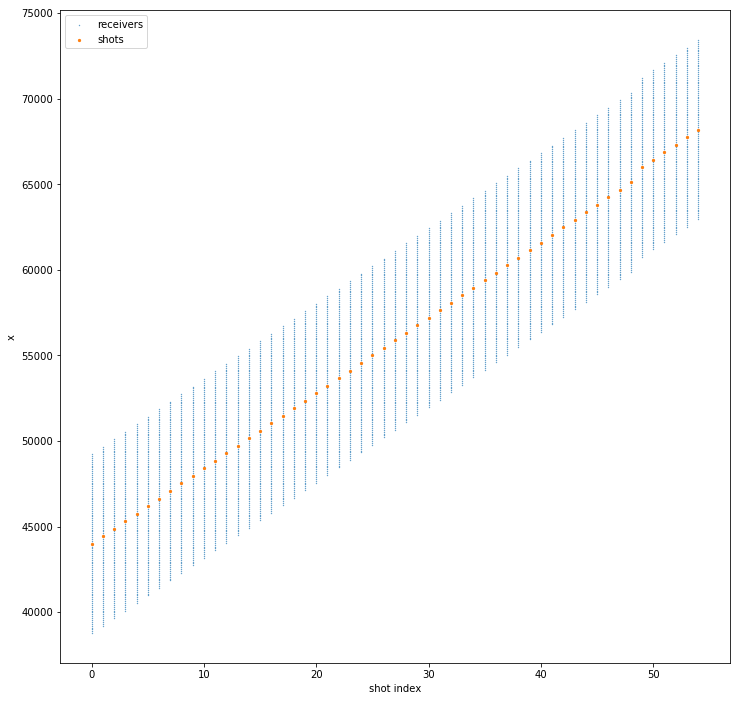

In [28]:
plt.figure(figsize=(12,12))
plt.scatter(np.arange(55).repeat(96), data.GroupX.values.reshape(-1), s=0.1, label='receivers')
plt.scatter(np.arange(55), data.SourceX[:,0].values.reshape(-1), s=5, label='shots')
plt.xlabel('shot index');
plt.ylabel('x');
plt.legend();

The coordinates in the dataset are in feet, but Tomo2D expects kilometers, so let's convert them and save the results as new variables.

In [8]:
data['SourceX_km'] = data.SourceX * 0.305e-3
data['GroupX_km'] = data.GroupX * 0.305e-3
data['SourceSurfaceElevation_km'] = data.SourceSurfaceElevation * 0.305e-3
data['ReceiverGroupElevation_km'] = data.ReceiverGroupElevation * 0.305e-3

To run travel time inversion with Tomo2D, a few files are required. The first of these, which I will call "picks.txt", contains the travel time picks. The format is described in the Tomo2D documentation. It mainly consists of providing the source and receiver coordinates, and the associated travel time. As the depth axis is assumed to point downward, I use the negative of the elevations as the depth of the sources and receivers. To ensure that they are in the earth, rather than being affected by the air velocity, I shift the elevations slightly by `srcrecdepth_km`.

It was difficult to pick the first breaks for the receivers at the end of the line for the last few sources, so I exclude those from the inversion.

In [9]:
picks_file = open('picks.txt', 'w')

num_src = 55
num_rcv = 96 * np.ones(55, np.int)
# for shots after 45, only use the first 75 receivers as picks
num_rcv[45:] = 75
minx = np.min(data.GroupX_km.values)
srcrecdepth_km = 0.0001
picks_file.write('%d\n' % num_src)
for src in range(num_src):
    picks_file.write('s %f %f %d\n' % (data.SourceX_km[src, 0] - minx,
                                       -(data.SourceSurfaceElevation_km[src, 0] - srcrecdepth_km),
                                       num_rcv[src]))
    for rcv in range(num_rcv[src]):
        pick_time = (all_predict[src*96 + rcv] - 10) * 0.002
        picks_file.write('r %f %f 0 %f 0.02\n' % (data.GroupX_km[src, rcv] - minx,
                                                  -(data.ReceiverGroupElevation_km[src, rcv] - srcrecdepth_km),
                                                  pick_time))
picks_file.close()

You can also specify the topography. There isn't a large variation in elevation over the survey area, but extracting topography from the dataset is a nice demonstration of how easy it is to work with seismic data in Python.

I begin by extracting the `x` and `z` coordinates of the sources and receivers. Since the same source will occur in many traces, and similarly for each receiver, I only use the first occurrence of each to avoid duplicates. I then do a 1D interpolation so that I can estimate the topography at each `x` in my inversion model grid. The result is plotted a few cells down.

In [10]:
rcv_group = data.groupby(data.GroupX_km).first()
shot_group = data.groupby(data.SourceX_km).first()

In [11]:
elevations = np.concatenate([rcv_group.ReceiverGroupElevation_km.values,
                             shot_group.SourceSurfaceElevation_km.values])
x_pos = np.concatenate([rcv_group.GroupX_km.values, shot_group.SourceX_km.values])

In [12]:
import scipy.interpolate

In [13]:
topo_func = scipy.interpolate.interp1d(x_pos, elevations, fill_value='extrapolate')

In [68]:
print(np.min(x_pos), np.max(x_pos), np.max(x_pos) - np.min(x_pos))

11.826375 22.394625 10.56825


In [14]:
x_new = np.arange(0, 10.6, 0.02) + np.min(x_pos)
topo_interp = topo_func(x_new)

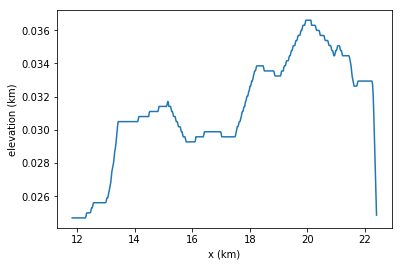

In [60]:
plt.plot(x_new, topo_interp)
plt.xlabel('x (km)');
plt.ylabel('elevation (km)');

I now write the range of `x` and `z` grid coordinates that I want the model grid to cover to files, along with the topography at the chosen `x` coordinates (again negated as the depth axis points down).

In [15]:
vfile_x = x_new - np.min(x_pos)
vfile_z = np.arange(0, 0.3, 0.005)
vfile_t = -topo_interp

vfile_x.tofile('x.txt', sep='\n')
vfile_z.tofile('z.txt', sep='\n')
vfile_t.tofile('t.txt', sep='\n')

I use Tomo2D's `gen_smesh` tool to convert these files into a starting model, with a velocity increasing from 4km/s at the surface by 0.5km/s per km depth.

In [71]:
!./gen_smesh -A4.0 -B0.5 -Xx.txt -Zz.txt -Tt.txt > v.in

Now it's time for the actual inversion. The cell below runs Tomo2D's `tt_inverse` tool for 30 iterations. I have chosen to apply quite a bit of smoothing to the result. I created the `vcorrt.in` file by hand. It specifies spatial correlations (which I set to be 0.5km in `x` and `z`).

In [56]:
!./tt_inverse -Mv.in -Gpicks.txt -I30 -SV1000 -CVvcorrt.in

kore1 kore2 kore2.1 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 LSQR iter= 56 nnode= 31800 ndata= 68670
LSQR iter= 115 nnode= 31800 ndata= 68670
LSQR iter= 116 nnode= 31800 ndata= 68670
LSQR iter= 116 nnode= 31800 ndata= 68670
LSQR iter= 115 nnode= 31800 ndata= 68670
LSQR iter= 115 nnode= 31800 ndata= 68670
LSQR iter= 115 nnode= 31800 ndata= 68670
LSQR iter= 115 nnode= 31800 ndata= 68670
kore1 kore2 kore2.1 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kore3 kor

In the cells below, I open and plot the inverted model. The result indicates that my guess of 4km/s at the surface might have been a bit too high, as the inversion has slowed it down to around 3.7km/s.

In [57]:
v1=np.fromfile('inv_out.smesh.30.1', sep=" ")
nx=530
nz=60
v1=v1[4+2*nx+nz:].reshape(nx,nz)

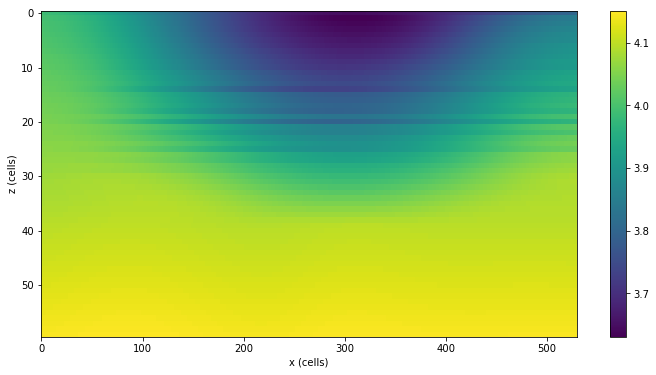

In [63]:
plt.figure(figsize=(12,6))
plt.imshow(v1.T, aspect='auto')
plt.colorbar();
plt.xlabel('x (cells)')
plt.ylabel('z (cells)')

## Conclusion
This picking tool is currently quite slow and fragile, but the convenience of being able to run it locally or remotely using a Jupyter notebook, and of having easy access to the results in Python, may compensate for this. Although it is only intended for demonstration, applying it to larger datasets may be possible. The main obstacle would probably be a shortage of memory. The prediction step, in particular, loads large parts of the dataset into memory. Running the prediction on batches of frames (`picks.predict(frame_ids)`) rather than on the whole dataset at once, might overcome that problem.

Using machine learning for picking seems to work quite well, although I certainly think there is room for improvement. One feature that may be desirable is an enforcement of continuity. At the moment, there is no penalty for predicting picks with large jumps between neighbouring traces. Another current shortcoming is the restriction of only having one pick per trace. This is reasonable when picking arrivals in seismic data (such as the first break picking example above), but may be problematic for picking seismic images where a fault could cause the same layer to occur at two depths in the same depth trace.

If you have suggestions for improvement, bug reports, or other comments, please [let me know](mailto:alan@ausargeo.com) or submit an issue or pull request on Github.